In [106]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt



In [6]:
all_tracking = []
for i in range(1,10):
  week = pd.read_csv("nfl-big-data-bowl-2024/tracking_week_" + str(i) + ".csv")
  all_tracking.append(week)

all_tracking_df = pd.concat(all_tracking, ignore_index=True)  # Combine into one DataFrame


In [7]:
players = pd.read_csv("nfl-big-data-bowl-2024/players.csv")

In [8]:
all_tracking_df = pd.merge(all_tracking_df, players, on = 'nflId')

In [9]:
#group the data into smaller chunks
#group by games, plays, and frame.

#compute the distances between every pair of player for each frame
#save this in a new csv filew for tracking_dist_week_X.csv

distance_list = []
frame_grouped = all_tracking_df.groupby(['gameId', 'playId', 'frameId'])

for(game_id, play_id, frame_id), frame_df in frame_grouped:
  players = frame_df[['nflId', 'x', 'y']].dropna()
  for (id1, x1, y1), (id2, x2, y2) in itertools.combinations(players.values, 2):
    distance = np.sqrt((x2-x1) **2 + (y2-y1) **2)

    distance_list.append({
      "gameId": game_id,
      "playId": frame_id,
      "frameId": frame_id,
      "player1": id1,
      "player2": id2,
      "distance": distance
    })

distances_df = pd.DataFrame(distance_list)


In [10]:
def flip_coordinates(row):
  if(row['playDirection'] == "left"):
    row['x'] = 120 - row['x']
    row['y'] = 53.3 - row['y']
    row['o'] = (row['o'] + 180) % 360  # Rotate by 180 degrees
    row['dir'] = (row['dir'] + 180) % 360  # Rotate by 180 degrees


  return row


all_tracking_df = all_tracking_df.apply(flip_coordinates, axis = 1)

In [11]:
tackles = pd.read_csv("nfl-big-data-bowl-2024/tackles.csv")

In [12]:
all_tracking_tackles = pd.merge(
    all_tracking_df,
    tackles,
    on=['gameId', 'playId', 'nflId'],
    how='left'  # Keep all rows from all_tracking_df, add tackle data if available
)

# Replace NaN values with 0 in the merged columns
all_tracking_tackles.fillna(0, inplace=True)


In [13]:
plays = pd.read_csv("nfl-big-data-bowl-2024/plays.csv")

In [25]:
all_tracking_tackles_play = pd.merge(all_tracking_tackles,
                                     plays,
                                     on = ['gameId', 'playId'],
                                     how = "left")

In [26]:
all_tracking_tackles_play['is_offense'] = all_tracking_tackles_play['club'] == all_tracking_tackles_play['possessionTeam']
all_tracking_tackles_play['is_defense'] = all_tracking_tackles_play['club'] == all_tracking_tackles_play['defensiveTeam']

In [27]:
all_tracking_tackles_play.columns

Index(['gameId', 'playId', 'nflId', 'displayName_x', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'height', 'weight', 'birthDate', 'collegeName',
       'position', 'displayName_y', 'tackle', 'assist', 'forcedFumble',
       'pff_missedTackle', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'fo

In [28]:
import numpy as np

# Step 1: Compute Ball Carrier's Attributes for Each Frame
ball_carrier_positions = all_tracking_tackles_play.groupby(['gameId', 'playId', 'frameId']).apply(
    lambda df: df.loc[df['nflId'] == df['ballCarrierId'], ['x', 'y', 's', 'dir', 'o', 'a', 'height', 'weight']]
).reset_index()

# Rename columns with "ball_carrier" prefix for clarity
ball_carrier_positions = ball_carrier_positions.rename(
    columns={
        'x': 'ball_carrier_x',
        'y': 'ball_carrier_y',
        's': 'ball_carrier_speed',
        'dir': 'ball_carrier_dir',
        'o': 'ball_carrier_orientation',
        'a': 'ball_carrier_acceleration',
        'height': 'ball_carrier_height',
        'weight': 'ball_carrier_weight'
    }
)

# Step 2: Merge Ball Carrier Attributes Back Into the Main DataFrame
all_tracking_tackles_play = all_tracking_tackles_play.merge(
    ball_carrier_positions[['gameId', 'playId', 'frameId',
                            'ball_carrier_x', 'ball_carrier_y',
                            'ball_carrier_speed', 'ball_carrier_dir',
                            'ball_carrier_orientation', 'ball_carrier_acceleration',
                            'ball_carrier_height', 'ball_carrier_weight']],
    on=['gameId', 'playId', 'frameId'],
    how='left'
)

/var/folders/98/0nc594rd7cq2v8bj1t1x697m0000gn/T/ipykernel_72597/2975878056.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ball_carrier_positions = all_tracking_tackles_play.groupby(['gameId', 'playId', 'frameId']).apply(


In [29]:
#Checkpoint 1 Save the data
all_tracking_tackles_play.to_csv("all_tracking_tackles_play.csv")

In [53]:
#Check Point 1 Continue
all_tracking_tackles_play = pd.read_csv("all_tracking_tackles_play.csv")

/var/folders/98/0nc594rd7cq2v8bj1t1x697m0000gn/T/ipykernel_81824/2425550641.py:2: DtypeWarning: Columns (20,41,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  all_tracking_tackles_play = pd.read_csv("all_tracking_tackles_play.csv")


In [54]:
all_tracking_tackles_play['distance_to_ball_carrier'] = np.where(
    all_tracking_tackles_play['is_defense'],
    np.sqrt(
        (all_tracking_tackles_play['x'] - all_tracking_tackles_play['ball_carrier_x'])**2 +
        (all_tracking_tackles_play['y'] - all_tracking_tackles_play['ball_carrier_y'])**2
    ),
    0  # Set to 0 for offensive players
)


In [55]:
columns_to_keep = [
    'gameId', 'playId', 'frameId', 'nflId', 'displayName_x', 'x', 'y', 's', 'a', 'o', 'dir',
    'ballCarrierId', 'height', 'weight', 'ballCarrierDisplayName', 'ball_carrier_x', 'ball_carrier_y',
    'ball_carrier_speed', 'ball_carrier_acceleration', 'ball_carrier_dir', 'ball_carrier_orientation',
    'ball_carrier_height', 'ball_carrier_weight',
    'distance_to_ball_carrier', 'is_offense', 'is_defense', 'tackle', 'assist', 'pff_missedTackle',
    'event', 'position'
]

# Keep only the relevant columns
all_tracking_tackles_play_filtered = all_tracking_tackles_play[columns_to_keep]

In [56]:
import pandas as pd
import numpy as np

# Function to compute Euclidean distances efficiently
def compute_defender_influence(ball_carrier_pos, defender_positions, defender_velocities):
    if not defender_positions:
        return {}
    defenders = np.array(defender_positions)
    velocities = np.array(defender_velocities).flatten()

    # Compute distances using numpy broadcasting
    distances = np.linalg.norm(defenders - np.array(ball_carrier_pos), axis=1)

    # Influence calculation (example: inverse distance weighted by velocity)
    influences = velocities / (distances + 1e-6)  # Avoid divide by zero
    return dict(zip(map(tuple, defenders), influences))

def compute_blocker_influence(defender_positions, blocker_positions, sigma = 5):
    if not blocker_positions:
        return {}
    defenders = np.array(defender_positions)
    blockers = np.array(blocker_positions)

    # Compute distances between each defender and all blockers
    dists = np.linalg.norm(defenders[:, None] - blockers, axis=2)
    blocker_influences = np.exp(-dists / sigma)  # Get closest blocker to each defender

    total_blocker_influence = np.sum(blocker_influences, axis=1)

    return dict(zip(map(tuple, defenders), total_blocker_influence))

# Grouped processing with correct playerId assignment
def process_frame(frame_data):
    ball_carrier = frame_data.loc[frame_data['nflId'] == frame_data['ballCarrierId'], ['x', 'y']]
    if ball_carrier.empty:
        return None  # Skip if no ball carrier

    ball_carrier_pos = ball_carrier.values[0]

    defense = frame_data[frame_data['is_defense']]
    offensive_players = frame_data[(frame_data['is_offense']) & (frame_data['nflId'] != frame_data['ballCarrierId'])]

    defender_positions = list(zip(defense['x'], defense['y']))
    defender_nfl_ids = list(defense['nflId'])  # Store correct player IDs
    defender_velocities = defense['s'].values.reshape(-1, 1)
    blocker_positions = list(zip(offensive_players['x'], offensive_players['y']))

    defender_influences = compute_defender_influence(ball_carrier_pos, defender_positions, defender_velocities)
    blocker_influences = compute_blocker_influence(defender_positions, blocker_positions)

    # Map (x, y) positions back to correct player IDs
    position_to_nfl_id = dict(zip(defender_positions, defender_nfl_ids))

    return pd.DataFrame({
        'gameId': frame_data['gameId'].iloc[0],
        'playId': frame_data['playId'].iloc[0],
        'frameId': frame_data['frameId'].iloc[0],
        'nflId': [position_to_nfl_id[d] for d in defender_influences.keys()],  # Correct player IDs
        'defender_influence': list(defender_influences.values()),
        'blocker_influence': [blocker_influences.get(d, 0) for d in defender_influences.keys()]
    })

# Process data using groupby and apply
tackle_features_df = (
    all_tracking_tackles_play_filtered
    .groupby(['gameId', 'playId', 'frameId'])
    .apply(process_frame)
    .reset_index(drop=True)  # Drop extra index
)

# Merge computed features back into the original dataset
all_tracking_tackles_play_filtered = all_tracking_tackles_play_filtered.merge(
    tackle_features_df,
    on=['gameId', 'playId', 'frameId', 'nflId'],
    how='left'
)

# Print a sample
print(all_tracking_tackles_play_filtered.head())


/var/folders/98/0nc594rd7cq2v8bj1t1x697m0000gn/T/ipykernel_81824/2509236417.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(process_frame)


       gameId  playId  frameId    nflId   displayName_x      x      y     s  \
0  2022090800      56        1  35472.0  Rodger Saffold  31.63  26.03  1.62   
1  2022090800      56        2  35472.0  Rodger Saffold  31.53  26.17  1.67   
2  2022090800      56        3  35472.0  Rodger Saffold  31.44  26.29  1.57   
3  2022090800      56        4  35472.0  Rodger Saffold  31.36  26.40  1.44   
4  2022090800      56        5  35472.0  Rodger Saffold  31.28  26.50  1.29   

      a      o  ...  distance_to_ball_carrier  is_offense is_defense  tackle  \
0  1.15  51.74  ...                       0.0        True      False     0.0   
1  0.61  50.98  ...                       0.0        True      False     0.0   
2  0.49  50.98  ...                       0.0        True      False     0.0   
3  0.89  52.38  ...                       0.0        True      False     0.0   
4  1.24  53.36  ...                       0.0        True      False     0.0   

  assist  pff_missedTackle         event  po

In [57]:
#Checkpoint 2 Save the data
all_tracking_tackles_play_filtered.to_csv("all_tracking_tackles_play_filtered.csv")

In [92]:
#Check Point 2 Continue
all_tracking_tackles_play_filtered = pd.read_csv("all_tracking_tackles_play_filtered.csv")

In [93]:
all_tracking_tackles_play_defense = all_tracking_tackles_play_filtered[all_tracking_tackles_play_filtered['is_defense']]
all_tracking_tackles_play_defense

,Unnamed: 0,gameId,playId,frameId,nflId,displayName_x,x,y,s,a,...,distance_to_ball_carrier,is_offense,is_defense,tackle,assist,pff_missedTackle,event,position,defender_influence,blocker_influence
22,22,2022090800,56,1,38577.0,Bobby Wagner,41.75,25.77,1.24,3.81,...,11.013632,False,True,0.0,0.0,0.0,0,ILB,0.112588,1.254574
23,23,2022090800,56,2,38577.0,Bobby Wagner,41.80,25.61,1.78,4.43,...,10.246878,False,True,0.0,0.0,0.0,pass_arrived,ILB,0.173711,1.260834
24,24,2022090800,56,3,38577.0,Bobby Wagner,41.84,25.42,2.21,4.20,...,9.464486,False,True,0.0,0.0,0.0,0,ILB,0.233504,1.270333
25,25,2022090800,56,4,38577.0,Bobby Wagner,41.86,25.17,2.70,3.87,...,8.646531,False,True,0.0,0.0,0.0,0,ILB,0.312264,1.284189
26,26,2022090800,56,5,38577.0,Bobby Wagner,41.88,24.88,3.05,3.19,...,7.812074,False,True,0.0,0.0,0.0,0,ILB,0.390421,1.289473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11657289,11657289,2022110700,3787,40,54606.0,Damarion Williams,33.45,29.73,1.92,2.40,...,12.336296,False,True,0.0,0.0,0.0,tackle,CB,0.155638,1.338559
11657290,11657290,2022110700,3787,41,54606.0,Damarion Williams,33.42,29.57,1.53,2.65,...,12.179265,False,True,0.0,0.0,0.0,0,CB,0.125623,1.403811
11657291,11657291,2022110700,3787,42,54606.0,Damarion Williams,33.39,29.43,1.28,2.51,...,12.045588,False,True,0.0,0.0,0.0,0,CB,0.106263,1.467758
11657292,11657292,2022110700,3787,43,54606.0,Damarion Williams,33.38,29.31,1.07,2.24,...,11.963047,False,True,0.0,0.0,0.0,0,CB,0.089442,1.525725


In [94]:
all_tracking_tackles_play_defense.columns

Index(['Unnamed: 0', 'gameId', 'playId', 'frameId', 'nflId', 'displayName_x',
       'x', 'y', 's', 'a', 'o', 'dir', 'ballCarrierId', 'height', 'weight',
       'ballCarrierDisplayName', 'ball_carrier_x', 'ball_carrier_y',
       'ball_carrier_speed', 'ball_carrier_acceleration', 'ball_carrier_dir',
       'ball_carrier_orientation', 'ball_carrier_height',
       'ball_carrier_weight', 'distance_to_ball_carrier', 'is_offense',
       'is_defense', 'tackle', 'assist', 'pff_missedTackle', 'event',
       'position', 'defender_influence', 'blocker_influence'],
      dtype='object')

In [95]:
def convert_height_to_inches(height):
    try:
        feet, inches = height.split('-')
        return int(feet) * 12 + int(inches)
    except:
        return None  # Return None if height is missing or malformed

all_tracking_tackles_play_defense['height'] = all_tracking_tackles_play_defense['height'].astype(str).apply(convert_height_to_inches)
all_tracking_tackles_play_defense['ball_carrier_height'] = all_tracking_tackles_play_defense['ball_carrier_height'].astype(str).apply(convert_height_to_inches)


/var/folders/98/0nc594rd7cq2v8bj1t1x697m0000gn/T/ipykernel_81824/1790345297.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tracking_tackles_play_defense['height'] = all_tracking_tackles_play_defense['height'].astype(str).apply(convert_height_to_inches)
/var/folders/98/0nc594rd7cq2v8bj1t1x697m0000gn/T/ipykernel_81824/1790345297.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tracking_tackles_play_defense['ball_carrier_height'] = all_tracking_tackles_play_defense['ball_carrier_height'].astype

In [96]:
all_tracking_tackles_play_defense['weight_diff'] = all_tracking_tackles_play_defense['weight'] - all_tracking_tackles_play_defense['ball_carrier_weight']
all_tracking_tackles_play_defense['height_diff'] = all_tracking_tackles_play_defense['height'] - all_tracking_tackles_play_defense['ball_carrier_height']

/var/folders/98/0nc594rd7cq2v8bj1t1x697m0000gn/T/ipykernel_81824/1490409540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tracking_tackles_play_defense['weight_diff'] = all_tracking_tackles_play_defense['weight'] - all_tracking_tackles_play_defense['ball_carrier_weight']
/var/folders/98/0nc594rd7cq2v8bj1t1x697m0000gn/T/ipykernel_81824/1490409540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_tracking_tackles_play_defense['height_diff'] = all_tracking_tackles_play_defense['height'] - all_t

<Axes: >

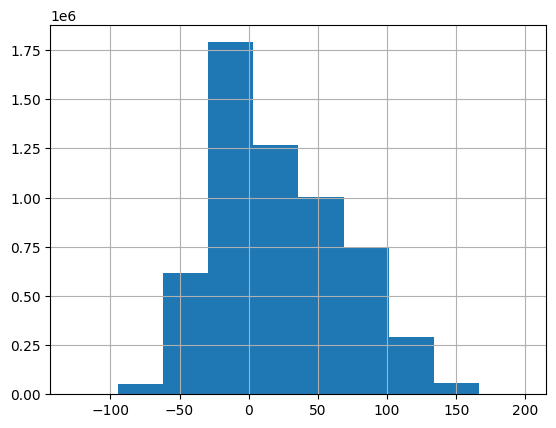

In [97]:
all_tracking_tackles_play_defense['weight_diff'].hist()

In [98]:
all_tracking_tackles_play_defense.to_csv("all_tracking_tackles_play_defense.csv")

In [116]:
all_tracking_tackles_play_defense = all_tracking_tackles_play_defense[['gameId', 'playId', 'frameId', 'nflId',
       'x', 'y', 's', 'a', 'o', 'dir',
       'ball_carrier_speed', 'ball_carrier_acceleration', 'ball_carrier_dir',
       'ball_carrier_orientation', 'ball_carrier_height',
       'ball_carrier_weight', 'distance_to_ball_carrier',
       'tackle', 'assist', 'pff_missedTackle', 'event',
       'position', 'defender_influence', 'blocker_influence', 'weight_diff',
       'height_diff']]

In [117]:
all_tracking_tackles_play_defense_tackles = all_tracking_tackles_play_defense[all_tracking_tackles_play_defense['tackle'] ==1]

In [118]:
all_tracking_tackles_play_defense_missed_tackles = all_tracking_tackles_play_defense[all_tracking_tackles_play_defense['pff_missedTackle'] ==1]

In [119]:
all_tracking_tackles_play_defense_tackles.columns

Index(['gameId', 'playId', 'frameId', 'nflId', 'x', 'y', 's', 'a', 'o', 'dir',
       'ball_carrier_speed', 'ball_carrier_acceleration', 'ball_carrier_dir',
       'ball_carrier_orientation', 'ball_carrier_height',
       'ball_carrier_weight', 'distance_to_ball_carrier', 'tackle', 'assist',
       'pff_missedTackle', 'event', 'position', 'defender_influence',
       'blocker_influence', 'weight_diff', 'height_diff'],
      dtype='object')